Importer les librairies nécessaires

In [2]:
%pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
import csv
import os
import cv2
import random
import matplotlib.pyplot as plt
import json

from langchain import PromptTemplate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

C:\Users\CYTech Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Constitution du dataset multi-modal</h1>

Utiliser le fichier d’annotations fourni avec le dataset Data_Herbier_trait_segmentation pour générer des descriptions textuelles des images.

In [24]:
# read the csv file and store the data in a list of dictionaries

annotations = []

with open('annotations-herbier.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:

        # change "ANGÂ\xa0419,00" to "ANG000419" by removing ',00' and replacing 'Â\xa0' (space) by as many 0 as needed
        for i in range(len(row['code']), 0, -1):
            match row['code'][i-1]:
                case '0':
                    row['code'] = row['code'][:i-1]
                case ',':
                    row['code'] = row['code'][:i-1]
                    break
                case _ :
                    break
        row['code'] = row['code'][:3] + row['code'][5:].zfill(6)

        # convert '1.0' and '0.0' to True and False
        row['epines'] = int(float(row['epines']))
        row['feuille_ext_acuminee'] = int(float(row['feuille_ext_acuminee']))

        annotations.append(row)

print(len(annotations), 'annotations loaded')

2530 annotations loaded


In [25]:
annotations[0]

{'code': 'ANG000419', 'epines': 1, 'feuille_ext_acuminee': 1}

In [26]:
# list the possible values for thorns and acuminate leaves
def unique_values(annotations, column):
    values = []
    examples = []
    for row in annotations:
        if row[column] not in values:
            values.append(row[column])
            examples.append(row)
    return values, examples

In [27]:
unique_values(annotations, 'epines')

([1, 0, -1],
 [{'code': 'ANG000419', 'epines': 1, 'feuille_ext_acuminee': 1},
  {'code': 'ANG029496', 'epines': 0, 'feuille_ext_acuminee': 1},
  {'code': 'P04006423', 'epines': -1, 'feuille_ext_acuminee': -1}])

In [28]:
unique_values(annotations, 'feuille_ext_acuminee')

([1, 0, -1],
 [{'code': 'ANG000419', 'epines': 1, 'feuille_ext_acuminee': 1},
  {'code': 'ANG000430', 'epines': 1, 'feuille_ext_acuminee': 0},
  {'code': 'ANG008150', 'epines': 1, 'feuille_ext_acuminee': -1}])

In [29]:
# Keep only annotations that have a corresponding image in the images folder

annotations = filter(lambda row: os.path.exists(f"images/{row['code']}.jpg"), annotations)
annotations = list(annotations)

print(len(annotations), 'annotations with images')

93 annotations with images


In [30]:
unique_values(annotations, 'epines')

([1, 0],
 [{'code': 'ANG000419', 'epines': 1, 'feuille_ext_acuminee': 1},
  {'code': 'ANG029496', 'epines': 0, 'feuille_ext_acuminee': 1}])

In [31]:
unique_values(annotations, 'feuille_ext_acuminee')

([1, 0, -1],
 [{'code': 'ANG000419', 'epines': 1, 'feuille_ext_acuminee': 1},
  {'code': 'ANG002056', 'epines': 1, 'feuille_ext_acuminee': 0},
  {'code': 'ANG015892', 'epines': 1, 'feuille_ext_acuminee': -1}])

In [32]:
# count number of plants with and without thorns

with_epines = []
without_epines = []
feuille_ext_acuminee_plus = []
feuille_ext_acuminee_zero = []
feuille_ext_acuminee_minus = []

for row in annotations:
    if row['epines']:
        with_epines.append(row)
    else:
        without_epines.append(row)
    if row['feuille_ext_acuminee']==1:
        feuille_ext_acuminee_plus.append(row)
    elif row['feuille_ext_acuminee']==0:
        feuille_ext_acuminee_zero.append(row)
    else:
        feuille_ext_acuminee_minus.append(row)

print(len(with_epines), 'plants with thorns')
print(len(without_epines), 'plants without thorns')
print(len(feuille_ext_acuminee_plus), 'plants with leaves=1')
print(len(feuille_ext_acuminee_zero), 'plants with leaves=0')
print(len(feuille_ext_acuminee_minus), 'plants with leaves=-1')

91 plants with thorns
2 plants without thorns
17 plants with leaves=1
75 plants with leaves=0
1 plants with leaves=-1


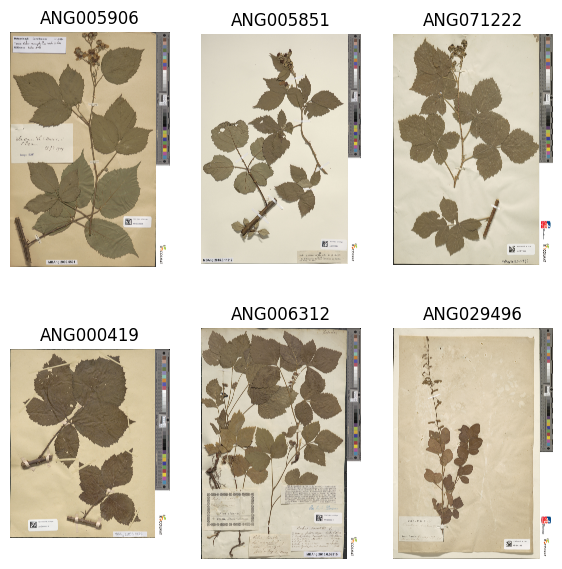

In [33]:
plt.figure(figsize=(7, 14))
feuille_plus_sample = random.sample(feuille_ext_acuminee_plus, 3)
feuille_zero_sample = random.sample(feuille_ext_acuminee_zero, 3)
for i in range(3):
    plant_plus = feuille_plus_sample[i]
    plant_zero = feuille_zero_sample[i]
    img_plus = cv2.cvtColor(cv2.imread(f"images/{plant_plus['code']}.jpg"), cv2.COLOR_BGR2RGB)
    img_zero = cv2.cvtColor(cv2.imread(f"images/{plant_zero['code']}.jpg"), cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 1+i)
    plt.imshow(img_plus)
    plt.title(plant_plus['code'])
    plt.axis('off')
    plt.subplot(2, 3, 1+i)
    plt.imshow(img_zero)
    plt.title(plant_zero['code'])
    plt.axis('off')

Les trois images du haut ont `feuille_ext_acuminee = 1` et les trois du bas `feuille_ext_acuminee = 0`. On en déduit que :
- 1 indique la présence de feuilles acuminées
- 0 indique l'absence
- -1 indique l'indétermination

De même pour les épines :
- 1 s'il y a des épines
- 0 s'il n'y en a pas

In [34]:
for annotation in annotations:
    annotation['epines'] = bool(annotation['epines'])
    annotation['feuille_ext_acuminee'] = True if annotation['feuille_ext_acuminee']==1 else False

In [35]:
# # create a prompt template

# template = """Rephrase the following information to describe the plant in other words:

# Information: A plant {epines} thorns. Its leaves {feuille_ext_acuminee}.
# Description:
# """

# prompt = PromptTemplate(template=template, input_variables=["epines", "feuille_ext_acuminee"])

In [36]:
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

def get_output(row):
  epines = 'with' if row['epines'] else 'without'
  feuille_ext_acuminee = 'are acuminate' if row['feuille_ext_acuminee'] else 'are not acuminate'
  # text = prompt.invoke({"epines": epines, "feuille_ext_acuminee": feuille_ext_acuminee})
  # inputs = tokenizer(text.text, return_tensors="pt")
  # outputs = model.generate(**inputs, max_new_tokens=50)
  # return tokenizer.batch_decode(outputs, skip_special_tokens=True)
  return [f"A plant {epines} thorns. Its leaves {feuille_ext_acuminee}."]

In [37]:
# Generate a description for a each image
for row in annotations:
    row['description'] = get_output(row)[0]

In [38]:
# Write the descriptions to a json file
with open('descriptions.json', 'w') as jsonfile:
    json.dump(annotations,jsonfile,indent=4)

Combiner chaque image avec sa description pour créer un dataset de tuples (image, phrase).

In [39]:
# import the json file
with open('descriptions.json') as jsonfile:
    descriptions = json.load(jsonfile)

dataset = []
for desc in descriptions:
    image = cv2.imread(f"images/{desc['code']}.jpg")
    dataset.append((cv2.cvtColor(image, cv2.COLOR_BGR2RGB),desc['description']))

print(len(dataset), "images loaded")

93 images loaded


Description: A plant with thorns. Its leaves are not acuminate.


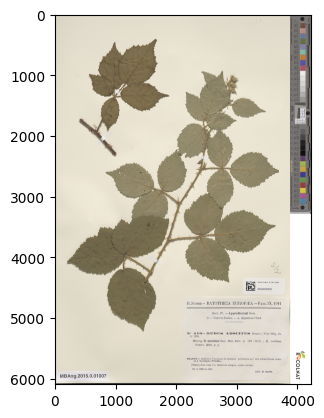

In [40]:
# print a random image with its description
random_row = random.choice(dataset)
print(f"Description: {random_row[1]}")
plt.imshow(random_row[0])
plt.show()

In [41]:
for img, desc in random.choices(dataset, k=10):
    h, w, c = img.shape
    print(f"Shape : ({w}, {h}, {c}) ; Ratio {round(h/w,2)}")

Shape : (4206, 6102, 3) ; Ratio 1.45
Shape : (3958, 5688, 3) ; Ratio 1.44
Shape : (6430, 9308, 3) ; Ratio 1.45
Shape : (6865, 9921, 3) ; Ratio 1.45
Shape : (3941, 5766, 3) ; Ratio 1.46
Shape : (3909, 5655, 3) ; Ratio 1.45
Shape : (4234, 6078, 3) ; Ratio 1.44
Shape : (3978, 5677, 3) ; Ratio 1.43
Shape : (3956, 5654, 3) ; Ratio 1.43
Shape : (6418, 9149, 3) ; Ratio 1.43


Les images sont très grandes et de tailles variées (mais toujours à peu près au même format 1.4). Pour les uniformiser, on les divise en deux et on ajuste la taille de chaque moitié.

In [42]:
# expand the dataset by reducing each image to 2 patches of size 1024x1024
patchified_dataset = []
for img, desc in dataset:
    patch_height = img.shape[0] // 2
    top_img = patch = cv2.resize(img[:patch_height], (1024, 1024))
    bottom_img = patch = cv2.resize(img[patch_height:], (1024, 1024))
    patchified_dataset.append((top_img, desc))
    patchified_dataset.append((bottom_img, desc))

print(len(patchified_dataset), "images")

186 images


Description: A plant with thorns. Its leaves are acuminate.


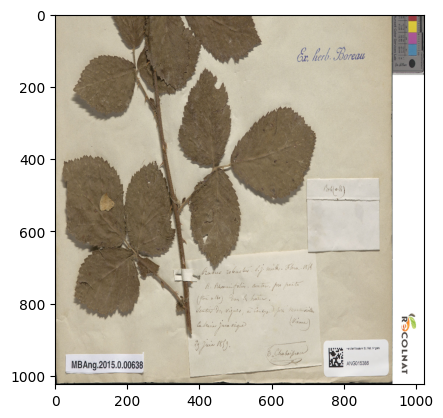

In [44]:
# print a random image with its description
random_row = random.choice(patchified_dataset)
print(f"Description: {random_row[1]}")
plt.imshow(random_row[0])
plt.show()